<a href="https://colab.research.google.com/github/Sukhdeep2006/Learning-TensorFlow/blob/main/009_TF_NLP_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LSTMs with `*SubWords*`

In [ ]:
import tensorflow as tf
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow.keras.layers as ll

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
url = 'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P'

path = tf.keras.utils.get_file('sentiments.csv', url)
dataset = pd.read_csv(path)

print(dataset.keys())

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()


Index(['Unnamed: 0', 'text', 'sentiment'], dtype='object')


## Lets now tokenize the data.

In [ ]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size,max_subword_length=5)
sentences_encoded = []
print(sentences[5])

for i, sentence in enumerate(sentences):
  sentences_encoded.append(tokenizer.encode(sentence))

print(sentences_encoded[5])

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [ ]:
# Separately print out each subword, decoded
encoded1 = tokenizer.encode(sentences[5])
print(encoded1)
for i in encoded1:
  print(tokenizer.decode([i]))

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Final PreProcessing:   

In [ ]:
import numpy as np

max_length = 50
trunc_type = 'post'
pad_type = 'post'

sentences_padded = pad_sequences(sentences_encoded, 50, padding=pad_type, truncating=trunc_type)

training_size =  int(len(sentences_padded) * 0.8)

training_sentences = np.array(sentences_padded[0:training_size])
testing_sentences = np.array(sentences_padded[training_size:])

training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])


### Lets first define a model without using any LSTM layer and see its performance, before we try using an LSTM layer.

In [ ]:
embedding_dim = 16

model_1 = tf.keras.models.Sequential([
                                      ll.Embedding(vocab_size, embedding_dim, input_length = max_length),
                                      ll.GlobalAveragePooling1D(),
                                      ll.Dense(6, activation='relu'),
                                      ll.Dense(1, activation= 'sigmoid') 
])
                                      
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30
model_1.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
history = model_1.fit(training_sentences, training_labels, epochs = num_epochs, validation_data=(testing_sentences, testing_labels))

Epoch 1/30
50/50 [==============================] - 1s 6ms/step - loss: 0.6892 - accuracy: 0.5982 - val_loss: 0.6906 - val_accuracy: 0.5263
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.6447 - val_loss: 0.6870 - val_accuracy: 0.5589
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6755 - accuracy: 0.6962 - val_loss: 0.6803 - val_accuracy: 0.6040
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.7181 - val_loss: 0.6670 - val_accuracy: 0.6717
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6442 - accuracy: 0.7508 - val_loss: 0.6508 - val_accuracy: 0.7343
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6193 - accuracy: 0.7941 - val_loss: 0.6422 - val_accuracy: 0.6617
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.5892 - accuracy: 0.8073 - val_loss: 0.6181 - val_accuracy: 0.7118
Epoch 8/30
50/50 [==

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(history , string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

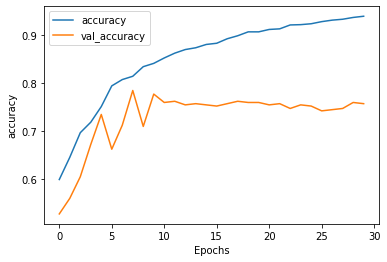

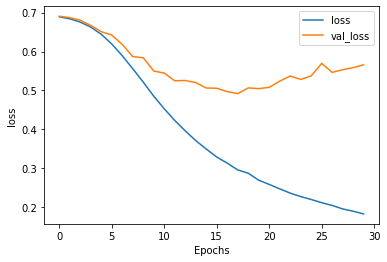

In [ ]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

By looking at the graph, its evident that our model is overfitting the training data. Lets define some fake reviews and see how our model performs on these.

### Lets first define a model to predict the sentiments of reviews:

In [ ]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=False ):
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [ ]:
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model_1, fake_reviews, show_padded_sequence=False)

I love this phone
[0.85162663]


Everything was cold
[0.09116298]


Everything was hot exactly as I wanted
[0.24483907]


Everything was green
[0.0797891]


the host seated us immediately
[0.37299234]


they gave us free chocolate cake
[0.6389912]


we couldn't hear each other talk because of the shouting in the kitchen
[0.01357505]




# Bidirectional LSTMs

## Define a function to train and show the results of models with different layers
In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.

In [ ]:
def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sentences, training_labels, epochs=num_epochs, 
                      validation_data=(testing_sentences, testing_labels))
  return history

def plot_results (history):
  plot_graph(history, "accuracy")
  plot_graph(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

### Add a bidirectional LSTM
Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 6s 47ms/step - loss: 0.6919 - accuracy: 0.5185 - val_loss: 0.7024 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 2s 31ms/step - loss: 0.6723 - accuracy: 0.5405 - val_lo

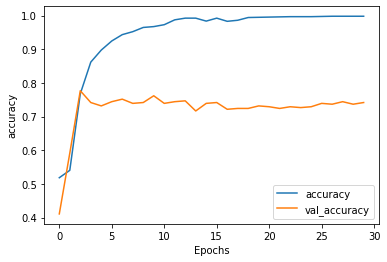

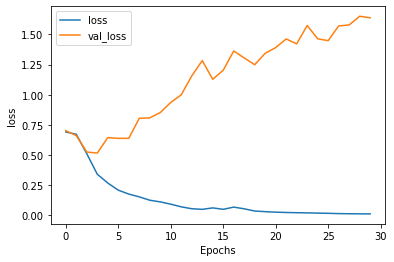

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.9989723]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.00761604]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.20060834]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.00836697]


[  1 109 228 540 237 635 24

In [ ]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


### Lets try using two layers of bidirectional LSTMs and see if it improves the results.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 198       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 11s 91ms/step - loss: 0.6887 - accuracy: 0.5229 - val_loss: 0.70

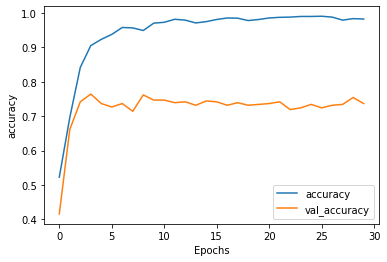

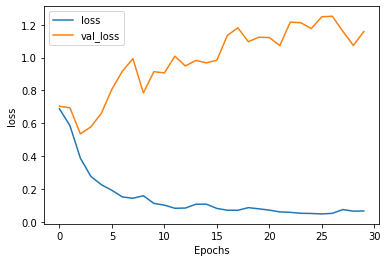

I love this phone
[0.9966212]


Everything was cold
[0.00953019]


Everything was hot exactly as I wanted
[0.01033404]


Everything was green
[0.00877434]


the host seated us immediately
[0.01135755]


they gave us free chocolate cake
[0.99721456]


we couldn't hear each other talk because of the shouting in the kitchen
[0.01884302]




In [ ]:
# Define the model
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True) ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=False) ), 

    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)




In [ ]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [ ]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model_1, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.8905479]


dreadful
[0.25402635]


stay away
[0.5652978]


everything was hot exactly as I wanted
[0.6534108]


everything was not exactly as I wanted
[0.43083143]


they gave us free chocolate cake
[0.6389912]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02094495]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.5761249]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.778965]


that place does not have quality meals and it isn't a good place to go for dinner
[0.81437576]




In [ ]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.99900454]


dreadful
[0.00343779]


stay away
[0.00666431]


everything was hot exactly as I wanted
[0.4595488]


everything was not exactly as I wanted
[0.00510675]


they gave us free chocolate cake
[0.57690805]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.00915682]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.01742363]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.99999815]


that place does not have quality meals and it isn't a good place to go for dinner
[0.03323779]




In [ ]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.9965506]


dreadful
[0.01303869]


stay away
[0.9562073]


everything was hot exactly as I wanted
[0.01146838]


everything was not exactly as I wanted
[0.01680407]


they gave us free chocolate cake
[0.99721456]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.05810186]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.02086058]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.55606866]


that place does not have quality meals and it isn't a good place to go for dinner
[0.04337052]


